In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd
import seaborn as sns
from fnmatch import fnmatch
from cycler import cycler

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

category =  "config2"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')

Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/home/users/nbachand/Cascade/city_block_cfd'

In [2]:
hm = 6
window_dim = hm/2/4
velTenMeters = 4

velocity_scaling = 1/velTenMeters
ventilation_scaling = velocity_scaling/(window_dim**2)

@utils.no_kwargs
@utils.dict_apply
def norm_vel(df):
    return df * velocity_scaling

@utils.no_kwargs
@utils.dict_apply
def norm_vent(df):
    return df * ventilation_scaling

@utils.no_kwargs
@utils.dict_apply
def abs_values(df):
    return df.abs()

@utils.no_kwargs
@utils.dict_apply
def flip_data(df):
    return -df


In [3]:
run = 23
qoisOutputed = ["mass_flux", "comp(u,0)"]
qois= ["mass_flux"]

probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'

# probes = probePost.Probes(probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed)
# probes.to_parquet(overwrite = True)

probes = probePost.Probes(probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed, file_type = "parquet")



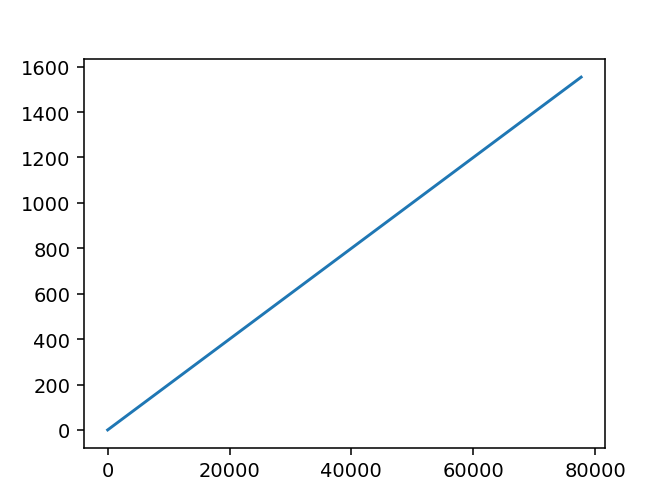

In [4]:
plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)
plt.show()

In [5]:
start = 30000
stop = -1
by = 1

In [6]:
# plt.figure()
# foo_mass = probes.data[("xwindow_0-0_h_3-0_Bx", qoisOutputed[0])].compute()
# foo_u = probes.data[("xwindow_0-0_h_3-0_Bx", qoisOutputed[1])].compute()
# foo_area = probes.areas["xwindow_0-0_h_3-0_Bx"]
# plt.plot(foo_mass.values/foo_u.values)
# plt.ylim(0,1.225*2)


In [7]:
# plt.figure()
# N = len(foo_mass)
# f, E = sp.signal.welch(foo_mass.values, fs = probes.dt, axis = 0, nperseg = N//4, scaling = 'density', detrend = 'constant') 
# plt.loglog(f, E)

## X Flow


In [8]:
@utils.no_kwargs
def norm_norm_blocks(data_dict):
    if category == "config2":
        return probePost.mul_names(data_dict, [name for name in probes.probe_names if "Bxz" in name or "Bz" in name], -1)
    return data_dict

# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "xwindow_" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_vent, norm_norm_blocks],
#     parrallel=True
#     )

## mean statistics
x_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_average, norm_norm_blocks],
    parrallel=False
    )

## rms statistics
x_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_rms],
    parrallel=False
    )

## Net flow
x_net = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, abs_values, probePost.time_average],
    parrallel=False
    )

x_flowStats = pd.concat([x_mean, x_rms, x_net], axis = "index").T
x_flowStats.columns = ["mean", "rms", "net"]

processing data took 2 seconds
processing data took 1 seconds
processing data took 1 seconds


In [9]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/xwindows', bbox = "tight")

# x_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xmean.csv')
# x_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xrms.csv')
# x_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xnet.csv')

## Z Flow


In [10]:
@utils.no_kwargs
def norm_norm_windows(data_dict):
    return probePost.mul_names(data_dict, [name for name in probes.probe_names if fnmatch(name, "*window_?-1*")], -1)

@utils.no_kwargs
def norm_norm_blocks(data_dict):
    if category == "config2":
        return probePost.mul_names(data_dict, [name for name in probes.probe_names if "Bxz" in name or "Bx" in name], -1)
    return data_dict

# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "zwindow" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_vent, norm_norm_windows, norm_norm_blocks],
#     parrallel=True
#     )

## mean statistics
z_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_average, norm_norm_windows, norm_norm_blocks],
    parrallel=False
    )

## rms statistics
z_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_rms],
    parrallel=False
    )

## Net flow
z_net = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, abs_values, probePost.time_average],
    parrallel=False
    )

z_flowStats = pd.concat([z_mean, z_rms, z_net], axis = "index").T
z_flowStats.columns = ["mean", "rms", "net"]

processing data took 11 seconds
processing data took 4 seconds
processing data took 4 seconds


In [11]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/zwindows', bbox_inches = "tight")

# z_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zmean.csv')
# z_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zrms.csv')
# z_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/znet.csv')

## Y Flow


In [12]:
# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "skylight" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_vent, norm_norm_skylights],
#     parrallel=True
#     )

## mean statistics
y_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_average, flip_data],
    parrallel=False
    )

## rms statistics
y_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_rms],
    parrallel=False
    )

## Net flow
y_net = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, abs_values, probePost.time_average],
    parrallel=False
    )

y_flowStats = pd.concat([y_mean, y_rms, y_net], axis = "index").T
y_flowStats.columns = ["mean", "rms", "net"]

processing data took 1 seconds
processing data took 1 seconds
processing data took 1 seconds


In [13]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/ywindows')

# y_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ymean.csv')
# y_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/yrms.csv')
# y_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ynet.csv')

## All Flow

In [14]:
flowStats = pd.concat([x_flowStats, y_flowStats, z_flowStats], axis = "index")
flowStats = probePost.addWindowDetails(flowStats, probes.get_avg_locations(), probes.areas)
flowStats


,mean,rms,net,windowType,openingType,windowNumber,houseType,blockType,area,x,y,z
xwindow_0-0_h_3-0,0.006757,0.054562,0.045389,xwindow_0-0,xwindow,0-0,3-0,,0.5625,54.032272,1.500000,10.000000
xwindow_0-0_h_3-0_Bx,0.050274,0.030432,0.051912,xwindow_0-0,xwindow,0-0,3-0,Bx,0.5625,-10.000000,1.500000,54.084718
xwindow_0-0_h_3-0_Bxz,-0.020989,0.046323,0.041650,xwindow_0-0,xwindow,0-0,3-0,Bxz,0.562841,-54.030225,1.499947,-10.000227
xwindow_0-0_h_3-0_Bz,-0.134964,0.049143,0.135168,xwindow_0-0,xwindow,0-0,3-0,Bz,0.5625,10.000000,1.500000,-54.082659
xwindow_0-0_h_3-1,0.007227,0.042183,0.033598,xwindow_0-0,xwindow,0-0,3-1,,0.5625,46.032316,1.500000,34.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
zwindow_2-1_h_3-4_Bz,-0.093115,0.038011,0.094763,zwindow_2-1,zwindow,2-1,3-4,Bz,0.5625,111.953060,1.500000,-64.000000
zwindow_2-1_sl,0.009795,0.039418,0.030819,zwindow_2-1,zwindow,2-1,sl,,0.56779,47.998929,1.498032,63.895663
zwindow_2-1_sl_Bx,0.105511,0.050466,0.106487,zwindow_2-1,zwindow,2-1,sl,Bx,0.5625,-63.927553,1.500000,48.000000
zwindow_2-1_sl_Bxz,0.018733,0.057333,0.049749,zwindow_2-1,zwindow,2-1,sl,Bxz,0.569793,-47.998657,1.497361,-63.893762


In [15]:

roomQois = ["mean", "net"]

connectedWindows = {
    "corner": [
        "xwindow_0-0",
        "zwindow_0-0",
        "skylight_0-0"
    ],
    "single": [
        "zwindow_1-0",
        "skylight_1-0"
    ],
    "dual": [
        "xwindow_0-1",
        "zwindow_0-1",
        "zwindow_1-1",
        "skylight_0-1",
        "skylight_1-1"
       ],
    "cross": [
        "zwindow_2-0",
        "zwindow_2-1",
        "skylight_2-0",
        "skylight_2-1"
    ]
}
sort_order = ["blockType", "houseType", "roomType"]
roomVentilation = probePost.roomStatistics(flowStats, connectedWindows, roomQois)
roomVentilation = roomVentilation.sort_values(by = sort_order)
sort_order.append("windowType")
flowStats = flowStats.sort_values(by = sort_order)
display(roomVentilation)
flowStats

,mean,net,contResid,houseType,blockType,roomType,x,y,z
corner_h_3-0,0.006617,0.045125,0.00028,3-0,,corner,55.016136,1.500000,9.022450
cross_h_3-0,0.005467,0.041892,-0.000392,3-0,,cross,64.000137,1.498593,11.969118
dual_h_3-0,0.028906,0.058172,0.000594,3-0,,dual,56.678986,1.498136,15.262142
single_h_3-0,0.000162,0.000192,-0.000324,3-0,,single,60.000000,1.500000,8.045070
corner_h_3-1,0.007126,0.033457,0.000202,3-1,,corner,47.015594,1.497615,33.055550
...,...,...,...,...,...,...,...,...,...
single_h_3-4_Bz,0.000053,0.000101,0.000107,3-4,Bz,single,104.023340,1.499420,-59.997758
corner_sl_Bz,0.078238,0.109324,-0.000485,sl,Bz,corner,57.358756,1.966833,-39.331883
cross_sl_Bz,0.167864,0.177196,0.000819,sl,Bz,cross,59.999651,2.203340,-48.000003
dual_sl_Bz,0.090965,0.120432,0.00099,sl,Bz,dual,62.769886,2.060568,-41.199981


,mean,rms,net,windowType,openingType,windowNumber,houseType,blockType,area,x,y,z,roomType
xwindow_0-0_h_3-0,0.006757,0.054562,0.045389,xwindow_0-0,xwindow,0-0,3-0,,0.5625,54.032272,1.500000,10.000000,corner
zwindow_0-0_h_3-0,-0.006477,0.053944,0.044862,zwindow_0-0,zwindow,0-0,3-0,,0.5625,56.000000,1.500000,8.044901,corner
zwindow_2-0_h_3-0,-0.005663,0.050987,0.041873,zwindow_2-0,zwindow,2-0,3-0,,0.5625,64.000000,1.500000,8.045031,cross
zwindow_2-1_h_3-0,0.005271,0.051103,0.041911,zwindow_2-1,zwindow,2-1,3-0,,0.56953,64.000274,1.497186,15.893204,cross
xwindow_0-1_h_3-0,0.019573,0.048968,0.042723,xwindow_0-1,xwindow,0-1,3-0,,0.5625,54.037566,1.500000,14.000000,dual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
xwindow_0-1_sl_Bz,0.041580,0.035111,0.045755,xwindow_0-1,xwindow,0-1,sl,Bz,0.564852,61.999991,1.498398,-37.999559,dual
zwindow_0-1_sl_Bz,-0.020727,0.057851,0.051150,zwindow_0-1,zwindow,0-1,sl,Bz,0.563764,63.925112,1.499700,-39.999613,dual
zwindow_1-1_sl_Bz,0.049881,0.050731,0.060804,zwindow_1-1,zwindow,1-1,sl,Bz,0.565068,63.924364,1.500130,-44.001726,dual
skylight_1-0_sl_Bz,-0.010583,0.055209,0.045778,skylight_1-0,skylight,1-0,sl,Bz,0.577597,58.007140,2.895897,-44.000605,single


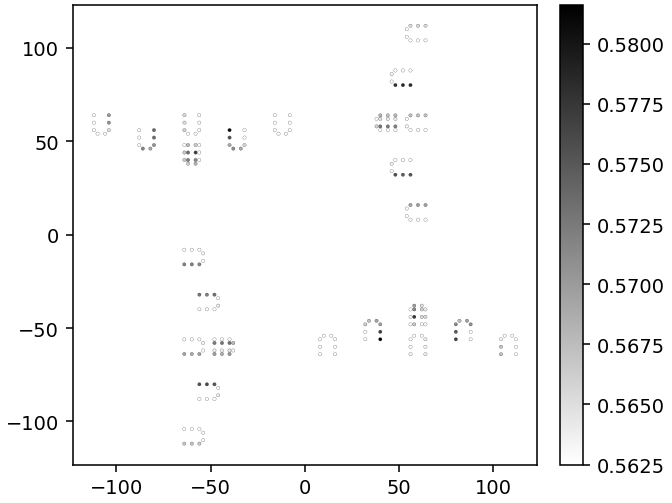

In [16]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["area"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

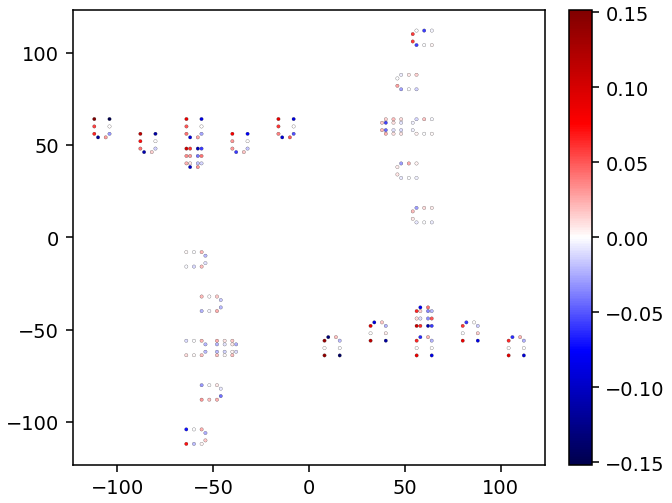

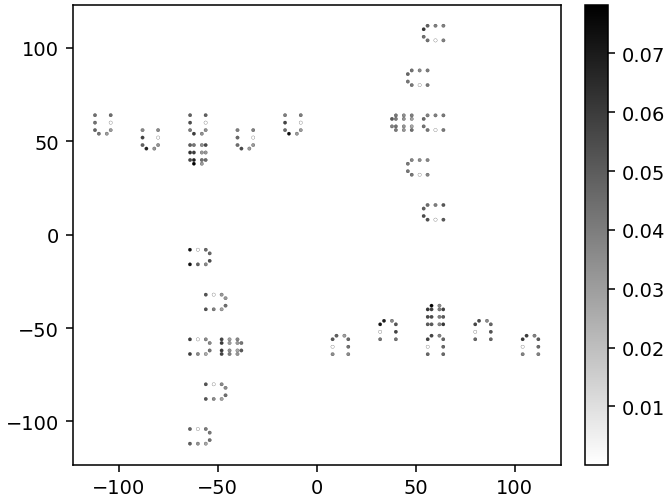

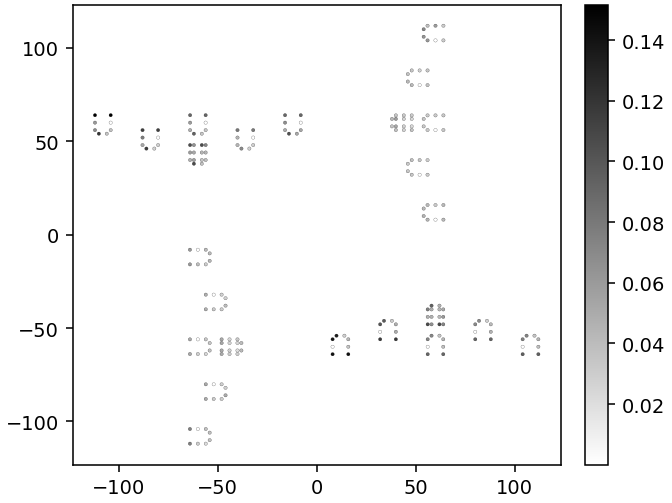

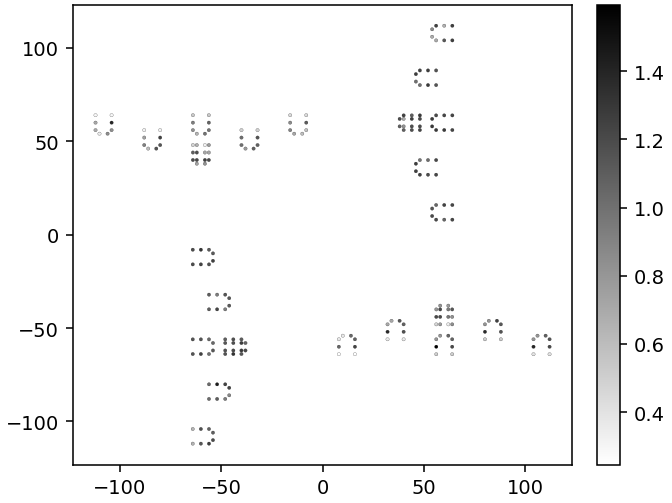

In [17]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean"], cmap='seismic', edgecolors="black", linewidths=.1, norm=colors.CenteredNorm())
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["rms"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["rms"]/flowStats["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsOnetInterior', bbox_inches="tight")

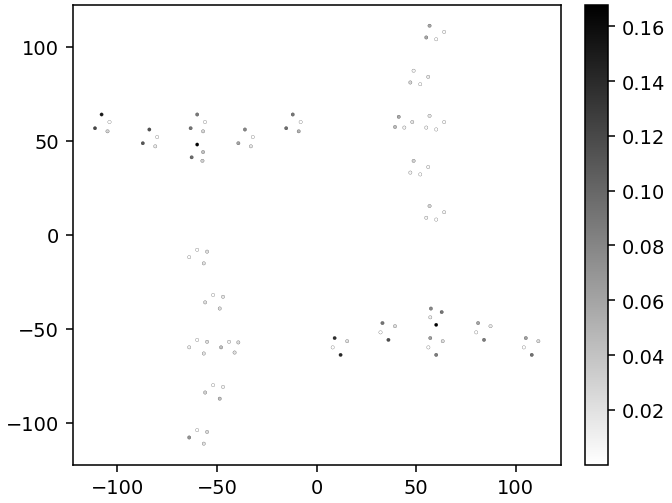

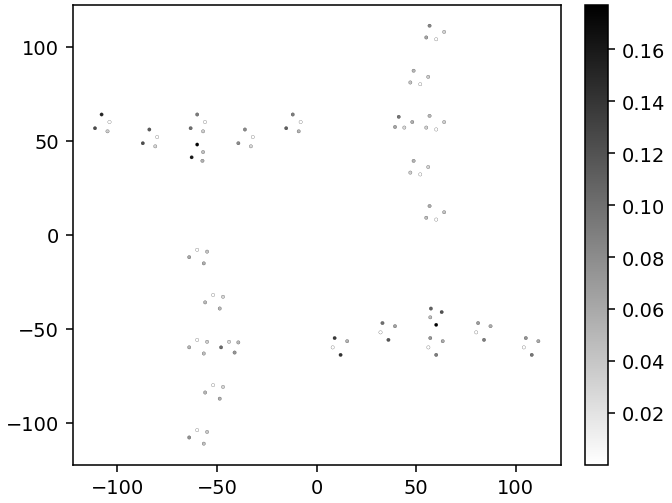

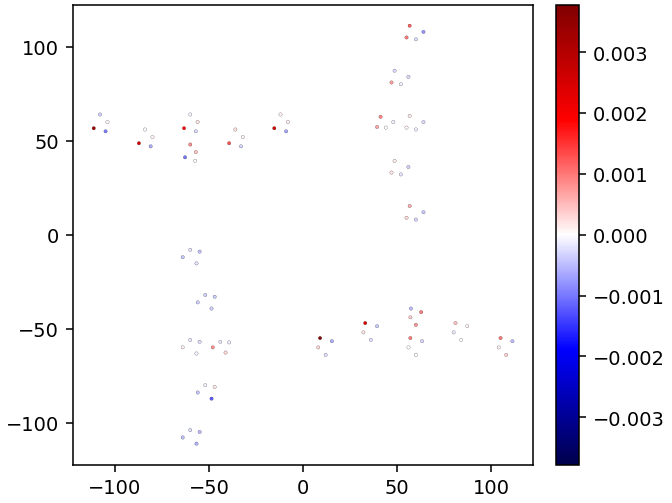

In [18]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["mean"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["contResid"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/residRooms', bbox_inches="tight")

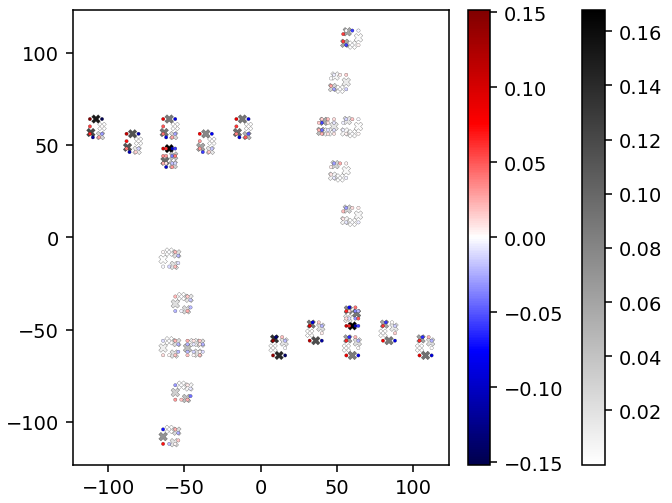

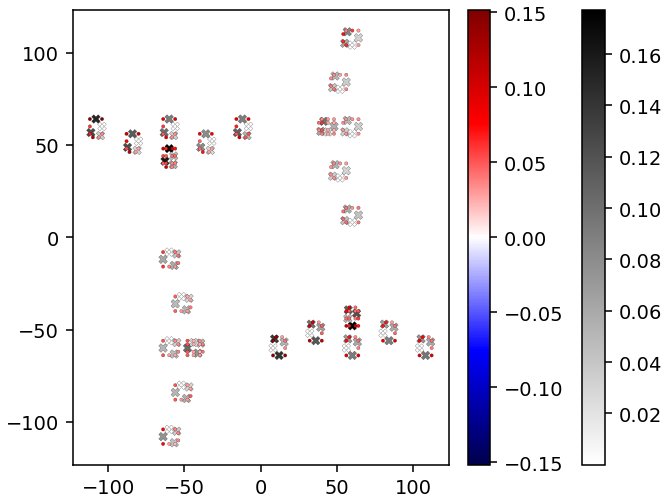

In [19]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im1=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=20, c=roomVentilation["mean"], cmap='binary', edgecolors="black", linewidths=.1, marker = 'X')
im2=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im1)
fig.colorbar(im2)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanWindowsRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im1=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=20, c=roomVentilation["net"], cmap='binary', edgecolors="black", linewidths=.1, marker = 'X')
im2=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["net"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im1)
fig.colorbar(im2)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netWindowsRooms', bbox_inches="tight")

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the violinplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda

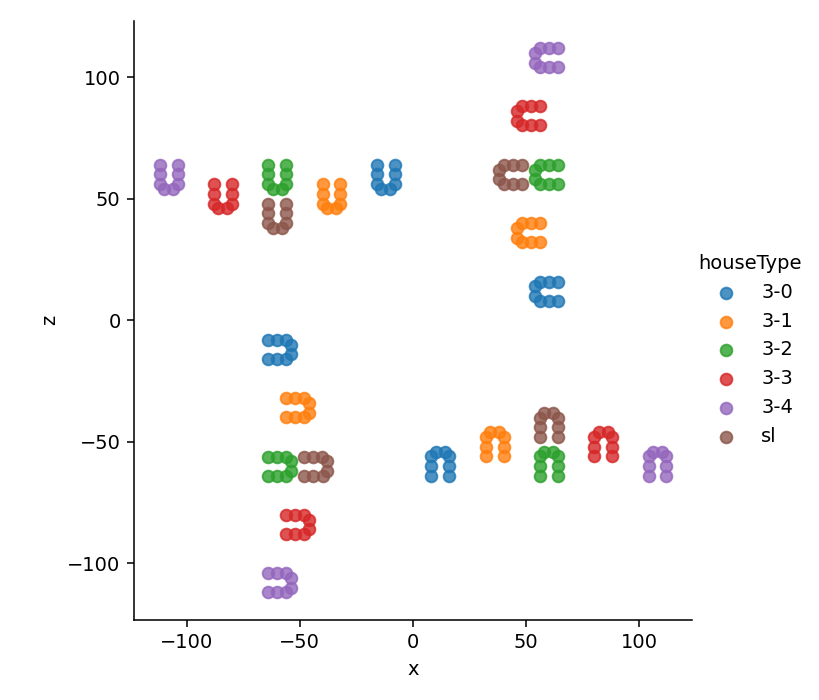

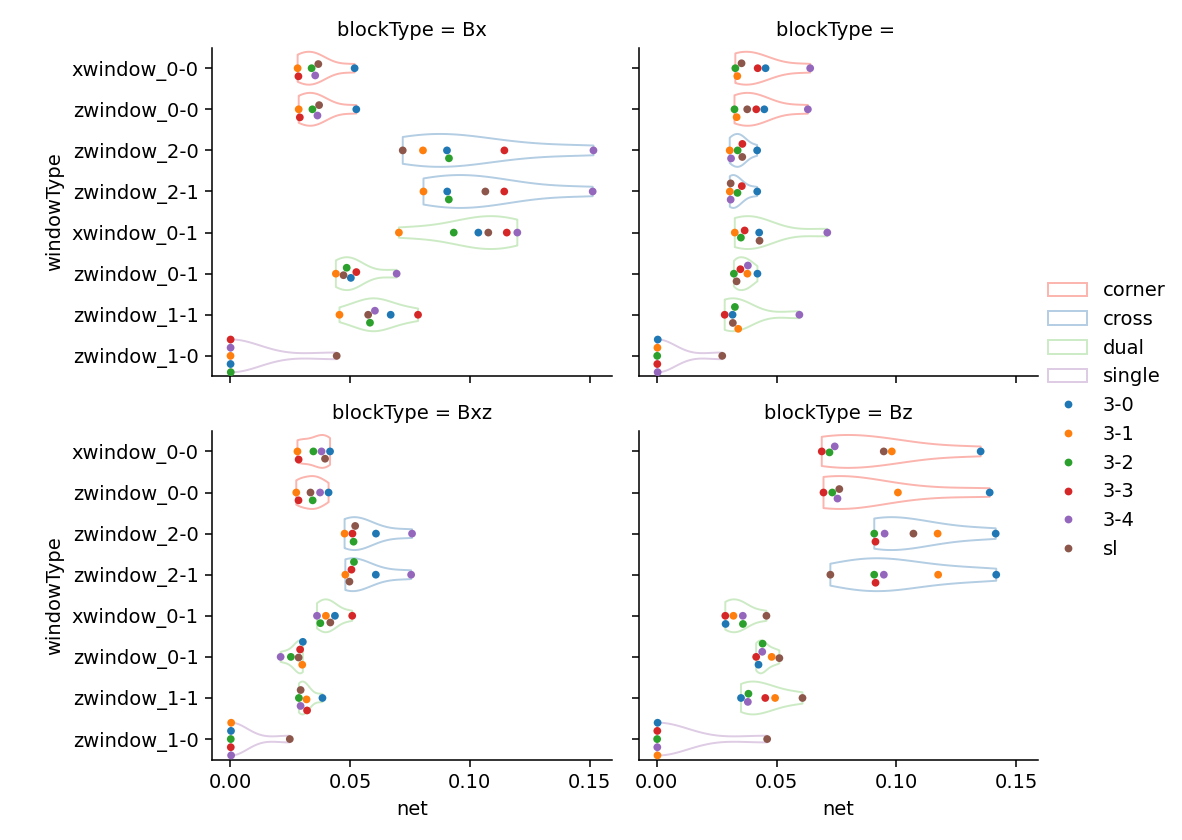

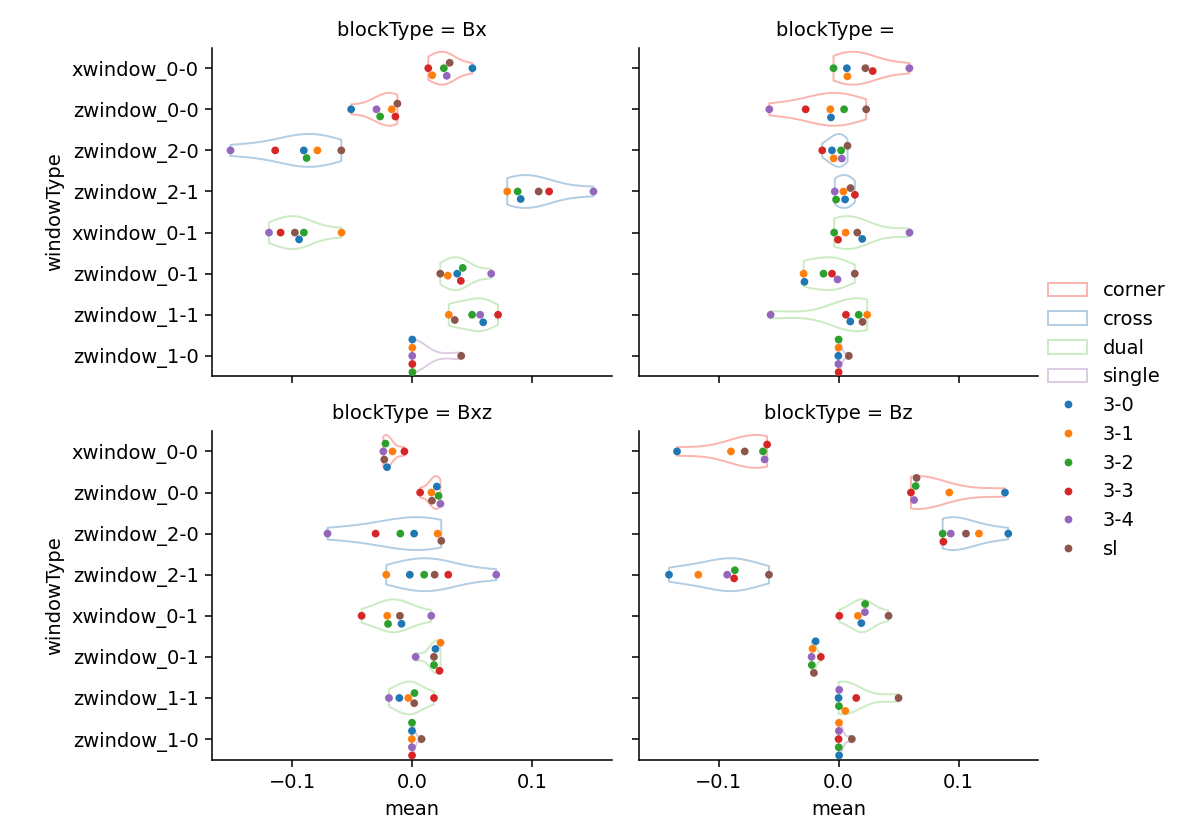

In [20]:
dfWindows = flowStats.loc[flowStats["openingType"].isin(["xwindow", "zwindow"])]

sns.lmplot(data = dfWindows, x = 'x', y = 'z', hue = 'houseType', fit_reg = False, palette = "tab10")
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/windowKeyLayout', bbox_inches="tight", dpi = 300)

g = sns.FacetGrid(dfWindows, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "net", "windowType", "roomType", inner = None, fill = False, palette = "Pastel1", linewidth = 1, density_norm = "width", cut = 0)
# g.map(sns.boxplot, "net", "windowType", color = "1", linewidth = 1, fliersize = 0)
g.map(sns.swarmplot, "net", "windowType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netWindowViolins', bbox_inches="tight")

g = sns.FacetGrid(dfWindows, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "mean", "windowType", "roomType", inner = None, fill = False, palette = "Pastel1", linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.swarmplot, "mean", "windowType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanWindowViolins', bbox_inches="tight")

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/en

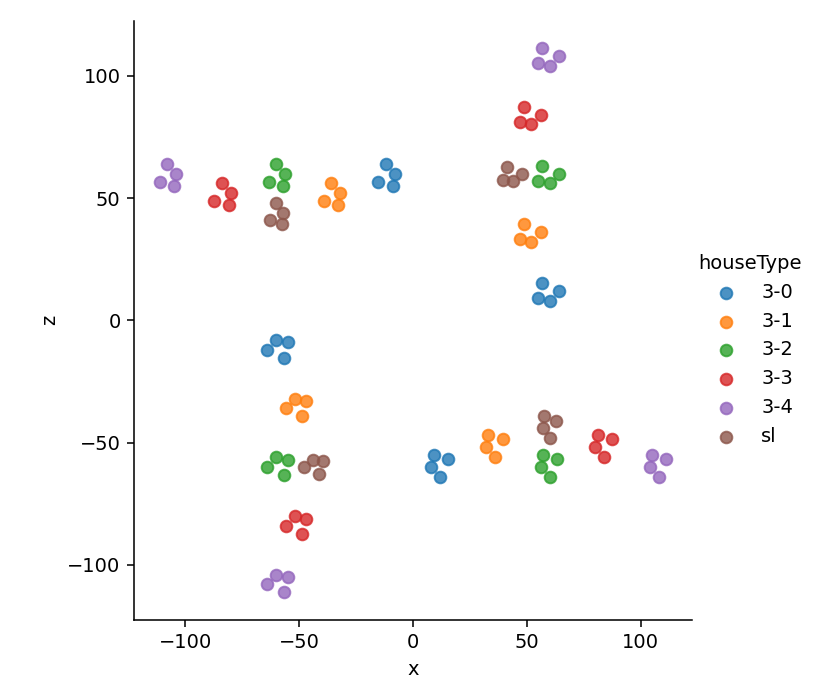

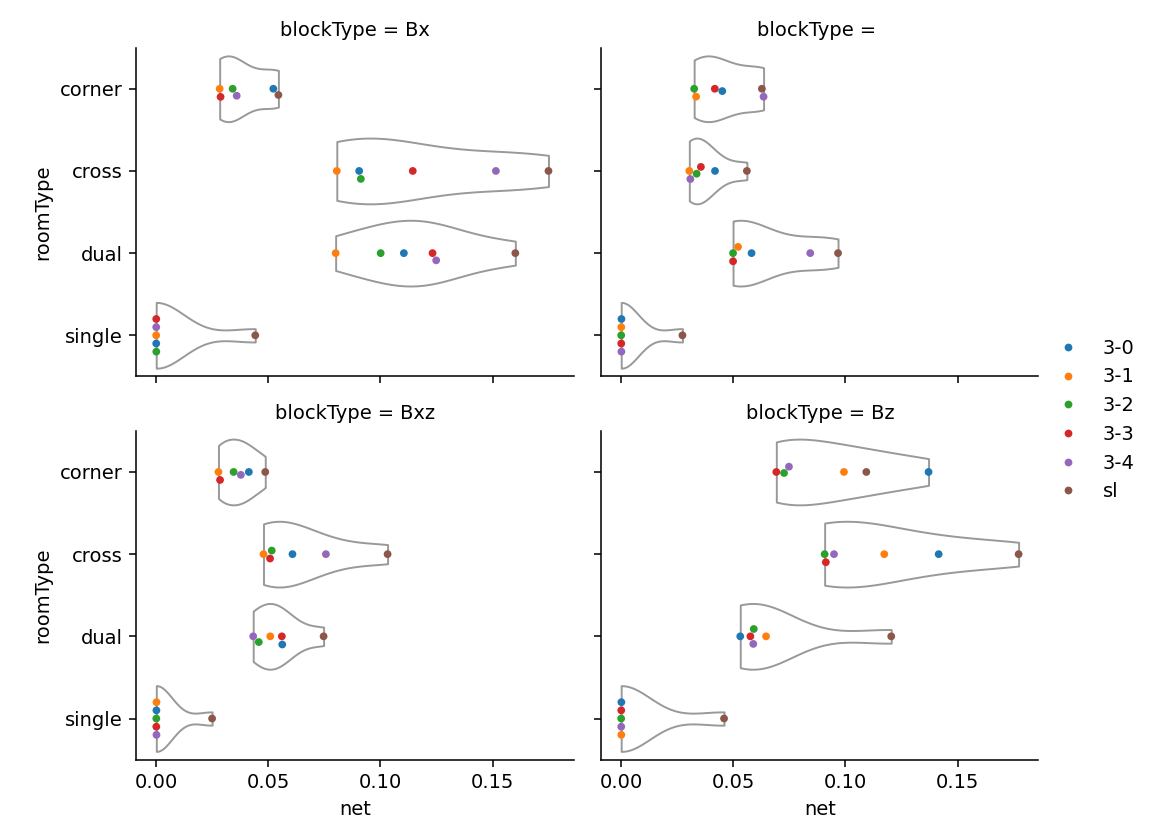

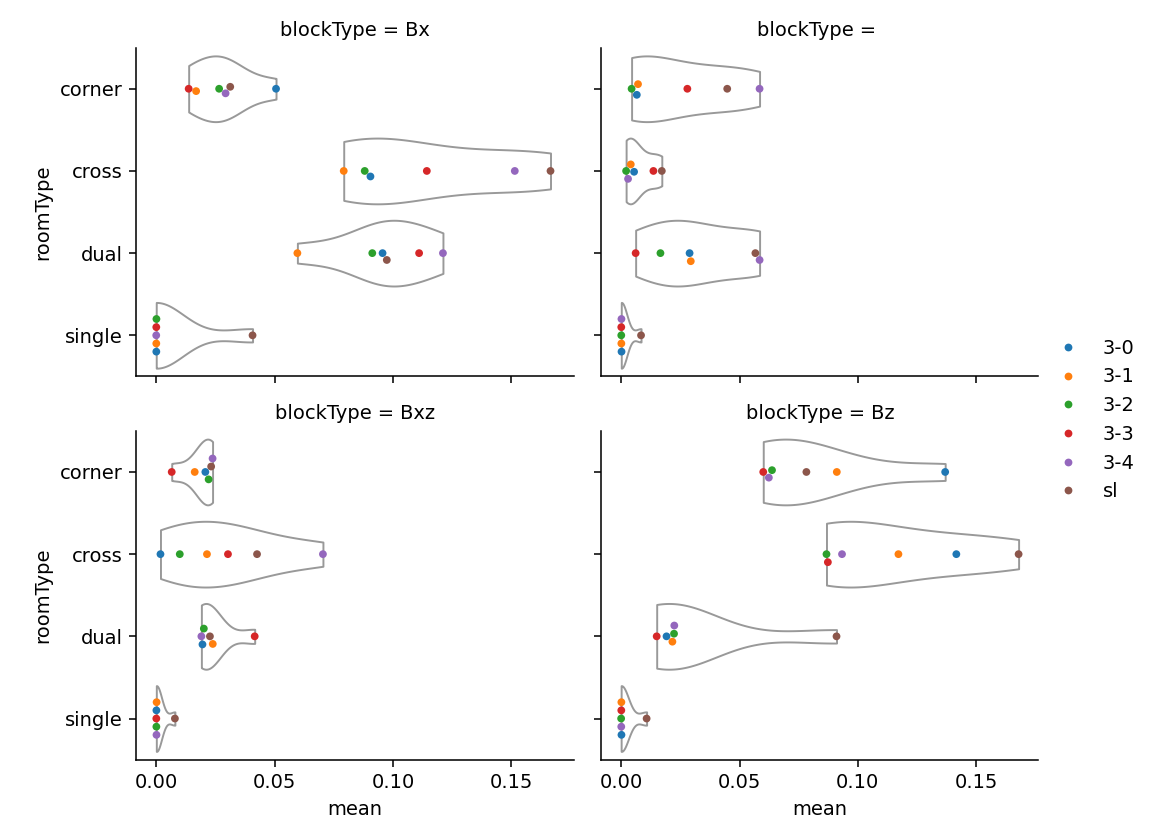

In [21]:
sns.lmplot(data = roomVentilation, x = 'x', y = 'z', hue = 'houseType', fit_reg = False, palette = "tab10")
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/roomKeyLayout', bbox_inches="tight", dpi = 300)

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "net", "roomType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
# g.map(sns.boxplot, "net", "roomType", color = "1", linewidth = 1, fliersize = 0)
g.map(sns.swarmplot, "net", "roomType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netRoomViolins', bbox_inches="tight")

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "mean", "roomType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.swarmplot, "mean", "roomType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRoomViolins', bbox_inches="tight")

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


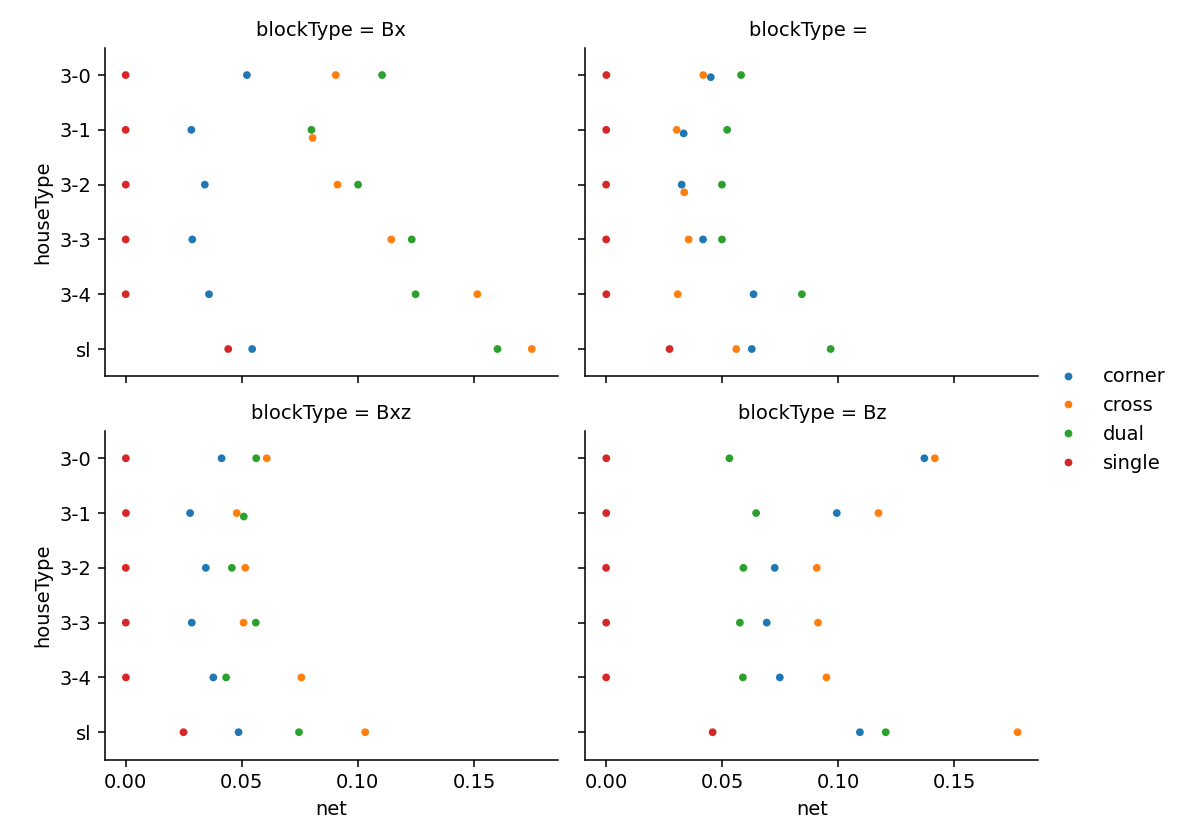

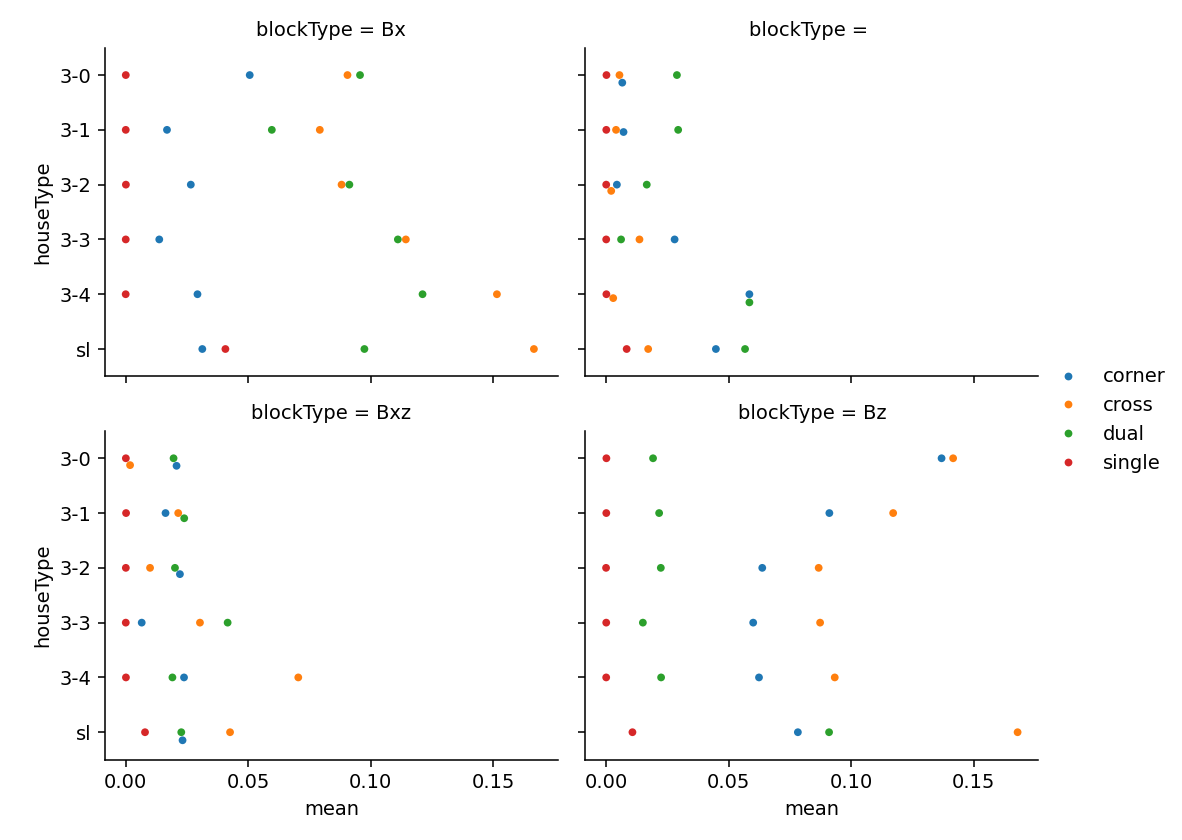

In [22]:
g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.swarmplot, "net", "houseType", "roomType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netHouseByRoom', bbox_inches="tight")

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.swarmplot, "mean", "houseType", "roomType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanHouseByRoom', bbox_inches="tight")

## Convergence

In [23]:
data = probes.statistics(
    names = [name for name in probes.probe_names if "door" not in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [],
    parrallel=False
    )

processing data took 5 seconds


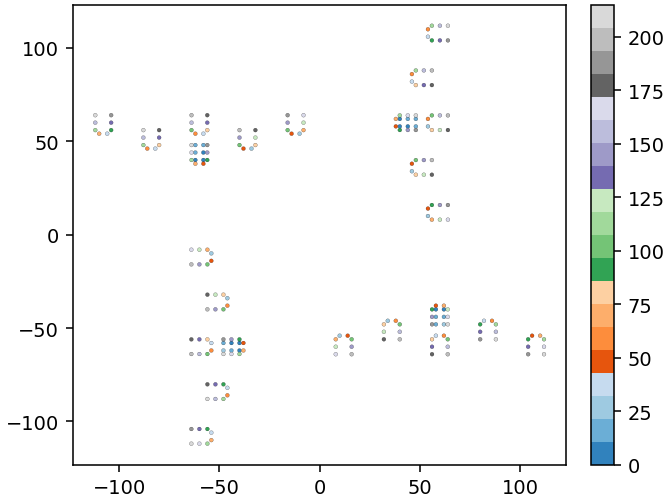

In [24]:
xPlot = data.index.values
yPlot = np.arange(len(data.keys()))

fig, ax=plt.subplots(1, 1, constrained_layout = True)
im=ax.scatter(flowStats.loc[data.keys(), 'x'], flowStats.loc[data.keys(), 'z'], s=4, c=yPlot, cmap='tab20c', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/dataMap', bbox_inches="tight")

/tmp/ipykernel_25349/2200143076.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(constrained_layout = True)


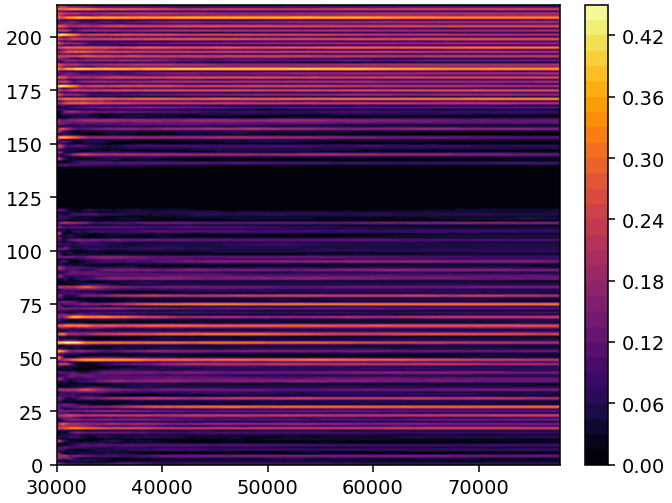

In [25]:
dataCumMean = probePost.cumulative_mean(data)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataCumMean.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)
# ax.set_yticks(yPlot)
# ax.set_yticklabels(dataCumMean.keys())

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourCumMean', bbox_inches="tight")

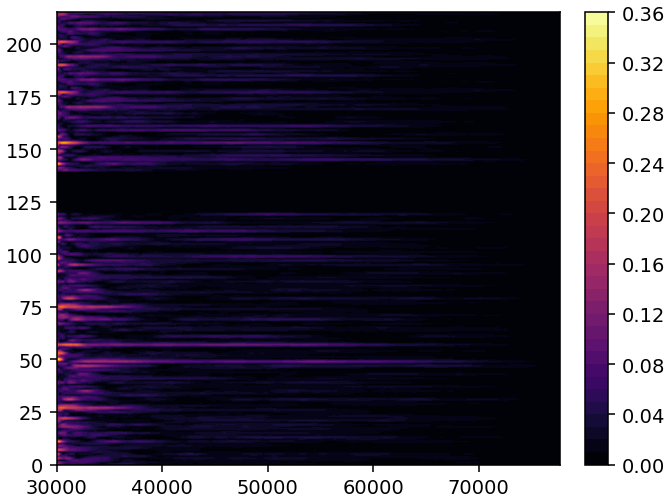

In [26]:
dataConv = probePost.convergence(dataCumMean)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataConv.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourConv', bbox_inches="tight")

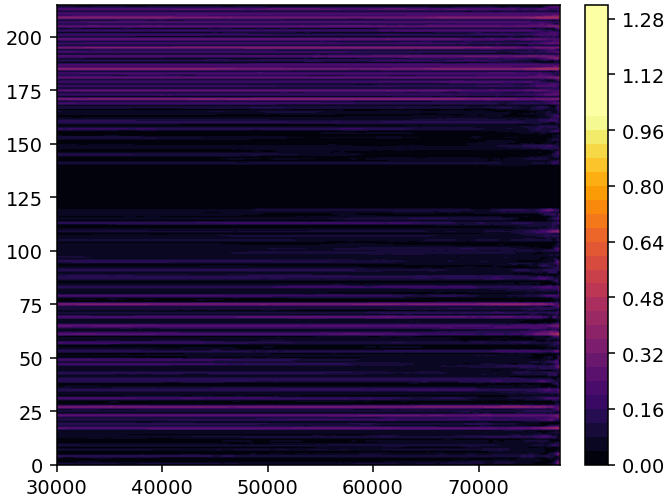

In [27]:
dataRevCumMean = probePost.reverse(data)
dataRevCumMean = probePost.cumulative_mean(dataRevCumMean)
dataRevCumMean = probePost.reverse(dataRevCumMean)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataRevCumMean.abs().T, cmap = "inferno", levels=40, vmax = 1)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourRevCumMean', bbox_inches="tight")

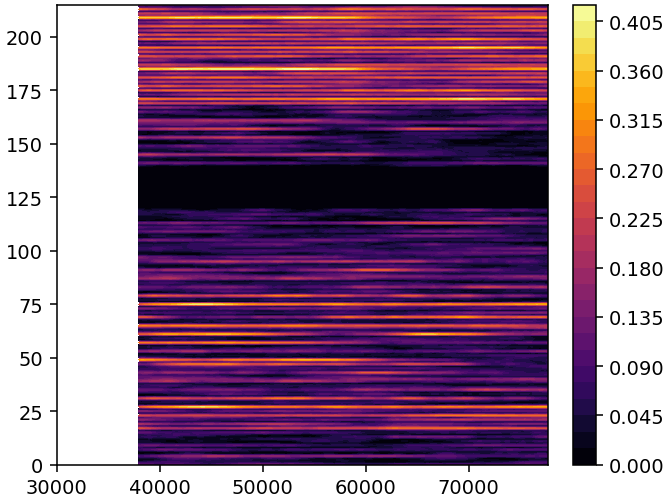

In [28]:
@utils.no_kwargs
@utils.dict_apply
def sma(df): 
    return df.rolling(8000).mean()
    
dataSMA = sma(data)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataSMA.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourSMA', bbox_inches="tight")